In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [4]:
df = pd.read_csv("retouren.csv")

# Data Cleaning

In [5]:
df["user_dob"] = pd.to_datetime(df.user_dob)
df["user_reg_date"] = pd.to_datetime(df.user_reg_date)
df["order_date"] = pd.to_datetime(df.order_date)
df["delivery_date"] = pd.to_datetime(df.delivery_date)

df["age"] = df.order_date.dt.year - df.user_dob.dt.year -((df.order_date.dt.date)<(df.user_dob.dt.date))
df = df.drop(df[df.item_price == 999].index)
df = df.drop(df[df.delivery_date < df.order_date].index)

df.loc[df.item_color == "brwon","item_color"] = "brown"
df.loc[df.item_color == "blau","item_color"] = "blue"
df.loc[df.item_color == "dark oliv","item_color"] = "dark olive"

df = df.drop(df[df.item_color == "?"].index)

df["acc_age"] = df.order_date - df.user_reg_date 
df["acc_age"] = df.acc_age.dt.days

df_mark = df.groupby(["item_id","item_size","item_color"]).agg(maxprice=("item_price","max")).reset_index()
df = pd.merge(df,df_mark)
df["markdown"] = 0
df.loc[df.item_price < df.maxprice,"markdown"] = 1
df.drop(df[df.delivery_date.isna()].index, inplace=True)

In [ ]:
df1 = df.copy()

In [ ]:
df1.sort_values('order_date', inplace=True)

# Generate order ID and order size
order_id_generator = df1.groupby(['order_date', 'user_id'], sort= False).size().reset_index(name='order_size')
order_id_generator['order_id'] = order_id_generator.index
df1 = pd.merge(df,order_id_generator,on=['user_id', 'order_date'], how='left')

**Item Order Count**

In [ ]:
df_order = df1.groupby(["order_id", "item_id"]).agg(color= ("item_color", "unique"), size= ("item_size", "unique"), color_count= ("item_color", "count"), size_count= ("item_size", "count"), returned= ("return", "mean")).reset_index()

In [ ]:
df_order

**Order_id_generator**

In [7]:
order_id_generator = df.groupby(['order_date', 'user_id'], sort= False).size().reset_index(name='order_size')
order_id_generator['order_id'] = order_id_generator.index
df = pd.merge(df,order_id_generator,on=['user_id', 'order_date'], how='left')

**Order_id**

In [8]:
df_order = df.groupby(["order_id", "item_id"]).agg(color= ("item_color", "unique"), size= ("item_size", "unique"), color_count= ("item_color", "count"), size_count= ("item_size", "count"), returned= ("return", "mean")).reset_index()
df_order1 = df_order[(df_order.color_count >1) | (df_order.size_count >1)]
#df_order1.drop(df_order1.loc[df_order1.returned == 0].index, inplace= True)
df_order1.drop(["color","size","color_count","size_count"], axis=1,inplace=True)
df = pd.merge(df,df_order1,on=["order_id","item_id"],how="left")

/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_79245/2376606678.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Age_bins**

In [9]:
df.loc[df.age > 100, "age"] = df.loc[df.age > 100, "age"] - 100
bins=[0,10,20,30,40,50,60,70,80,90,100]
df["age"] = pd.cut(df.age,bins=bins)

**Return Ratio**

In [10]:
df_return_ratio = df.groupby("item_id").agg(returned = ("return", "sum"), item_order= ("return", "count")).reset_index()

In [11]:
df_return_ratio["not_returned"] = df_return_ratio.item_order - df_return_ratio.returned
df_return_ratio["return_ratio"] = df_return_ratio.returned / df_return_ratio.item_order

In [12]:
df_return_ratio.drop(["returned","item_order","not_returned"],axis=1,inplace=True)

In [13]:
df = pd.merge(df,df_return_ratio,on="item_id",how="left")

In [ ]:
df

# Testdaten

In [14]:
df_grad = df.copy()

In [15]:
df_grad = df_grad[df_grad.age.isna() == False]

In [16]:
X = pd.get_dummies(df_grad[["item_id","item_size", "item_color",	"brand_id",	"item_price",	"user_id",	"user_title",	"user_state",	"age",	"acc_age",	"markdown", "return_ratio"]], dummy_na= True)
y = df_grad["return"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# DecisionTreeClassifier 

In [ ]:
dtc = DecisionTreeClassifier(max_depth= 1, min_samples_split=2)
dtc.fit(X_train, y_train)

y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

print(f"{'Accuracy Train':17} {accuracy_score(y_train, y_pred_train):10.5f}, {'Accuracy Test':17} {accuracy_score(y_test, y_pred_test):10.5f}")
print(f"{'Recall Train':17} {recall_score(y_train, y_pred_train):10.5f}, {'Recall Test':17} {recall_score(y_test, y_pred_test):10.5f}")
print(f"{'Precision Train':17} {precision_score(y_train, y_pred_train):10.5f}, {'Precision Test':17} {precision_score(y_test, y_pred_test):10.5f}")

nodes = plot_tree(dtc, rounded=True, filled=True, fontsize=14, class_names=["not returned", "returned"], feature_names=X_train.columns)

# Baselinemodell mit Crossvalidation durch Kfold (Code aus dem Internet)

In [18]:
crossvalidation = KFold(n_splits= 10, shuffle= True, random_state= 1)
for depth in range (1,10):
 tree_classifier = tree.DecisionTreeClassifier(max_depth = depth, random_state= 1)
 if tree_classifier.fit(X_train, y_train).tree_.max_depth < depth:
  break
 score = np.mean(cross_val_score(tree_classifier, X_train, y_train, scoring= "accuracy", cv= crossvalidation, n_jobs= 1))
 print(depth, score)

1 0.6241551427024572
2 0.6241551427024572
3 0.6241551427024572
4 0.6244238444866863
5 0.6240723657131537
6 0.6252916258908763
7 0.6237005374718839
8 0.6212210491888392
9 0.6201258840447534


# Mit Code aus Ü8 und aus dem Internet: Baseline Modell

In [19]:
min_samples = [2, 10, 20, 50, 100]
kf = KFold(n_splits= 10, shuffle= True, random_state= 1)
best_mean_score = 0
best_combination = dict(max_depth= None, min_samples= 2)

for depth in range(1,19):
 for min_sample in min_samples:
  scores = []
  classifier = DecisionTreeClassifier(max_depth= depth, min_samples_split= min_sample, random_state= 0)
  if classifier.fit(X_train, y_train).tree_.max_depth < depth:
   break
  score = np.mean(cross_val_score(classifier, X_train, y_train, scoring= "accuracy", cv= kf, n_jobs= 1))
  scores.append(score)

  mean_score = np.mean(np.array(scores))
 if mean_score > best_mean_score:
  best_combination["max_depth"] = depth
  best_combination["min_samples"] = min_sample
  best_mean_score = mean_score

In [20]:
print(f"Best Mean_score: {best_mean_score}, Best Max_depth: {best_combination['max_depth']}, Best Min_samples_split: {best_combination['min_samples']}")

Best Mean_score: 0.6252089769930609, Best Max_depth: 6, Best Min_samples_split: 100


In [21]:
best_dtc = DecisionTreeClassifier(max_depth= best_combination["max_depth"], min_samples_split= best_combination["min_samples"], random_state= 0)
best_dtc.fit(X_train, y_train)

y_pred_train_best_dtc = best_dtc.predict(X_train)
y_pred_test_best_dtc = best_dtc.predict(X_test)

print(f"{'Accuracy Train':17} {accuracy_score(y_train, y_pred_train_best_dtc):10.5f}, {'Accuracy Test':17} {accuracy_score(y_test,y_pred_test_best_dtc):10.5f}")
print(f"{'Recall Train':17} {recall_score(y_train, y_pred_train_best_dtc):10.5f}, {'Recall Test':17} {recall_score(y_test,y_pred_test_best_dtc):10.5f}")
print(f"{'Precision Train':17} {precision_score(y_train, y_pred_train_best_dtc):10.5f}, {'Precision Test':17} {precision_score(y_test,y_pred_test_best_dtc):10.5f}")


Accuracy Train       0.63339, Accuracy Test        0.62526
Recall Train         0.67436, Recall Test          0.66372
Precision Train      0.62886, Precision Test       0.62108


# GradientBoostingClassifier

In [ ]:
clf = GradientBoostingClassifier(n_estimators= 100, learning_rate= 1, max_depth= 8, random_state= 0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

**Rechenzeit zu lange (bei ca. 80min abgebrochen)**

In [ ]:
gs_crossvalidation = GridSearchCV(
 estimator= GradientBoostingClassifier(),
 param_grid= dict(n_estimators= [100, 500, 1000, 2000], learning_rate= [0.0001, 0.001, 0.01, 0.1], max_depth= [1, 3, 5, 7], subsample= [0.25, 0.5, 0.75, 1], random_state= [0]),
 scoring= "accuracy",
 n_jobs= 1,
 cv= kf
 ).fit(X_train, y_train)
print(f"Best parameters: {gs_crossvalidation.best_params_}, best score: {gs_crossvalidation.best_score_}")

In [22]:
gs_crossvalidation1 = GridSearchCV(
 estimator= HistGradientBoostingClassifier(),
 param_grid= dict(max_iter= [100], learning_rate= [0.001, 0.01, 0.1], max_depth= [1, 3, 5], random_state= [1]),
 scoring= "accuracy",
 n_jobs= 1,
 cv= kf
 ).fit(X_train, y_train)
print(f"Best parameters: {gs_crossvalidation1.best_params_}, best score: {gs_crossvalidation1.best_score_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 100, 'random_state': 1}, best score: 0.6332263299739207


In [23]:
best_gbc = HistGradientBoostingClassifier(max_iter= 100, max_depth= 5, random_state= 1, learning_rate= 0.1).fit(X_train, y_train)
score = np.mean(cross_val_score(best_gbc, X_train, y_train, scoring= "accuracy", cv= kf, n_jobs=1))
score

0.6332263299739207

In [24]:
y_pred_train_best_gbc = best_gbc.predict(X_train)
y_pred_test_best_gbc = best_gbc.predict(X_test)

print(f"{'Accuracy Train':17} {accuracy_score(y_train, y_pred_train_best_gbc):10.5f}, {'Accuracy Test':17} {accuracy_score(y_test,y_pred_test_best_gbc):10.5f}")
print(f"{'Recall Train':17} {recall_score(y_train, y_pred_train_best_gbc):10.5f}, {'Recall Test':17} {recall_score(y_test,y_pred_test_best_gbc):10.5f}")
print(f"{'Precision Train':17} {precision_score(y_train, y_pred_train_best_gbc):10.5f}, {'Precision Test':17} {precision_score(y_test,y_pred_test_best_gbc):10.5f}")

Accuracy Train       0.65147, Accuracy Test        0.62848
Recall Train         0.67970, Recall Test          0.65800
Precision Train      0.64897, Precision Test       0.62617


# Aufgabe 5 NOCH ANPASSEN !

In [ ]:
y_pred_test_best_gbc, y_test

In [ ]:
X_test["return1"] = y_pred_test_best_gbc
X_test["return_true"] = y_test
X_test["idk"] = X_test.return1 == X_test.return_true
df_aufgabe6 = X_test[X_test.return1 == 1]
df_aufgabe6["sum"] = 0
df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5
df_aufgabe6.loc[df_aufgabe6.idk == False,"sum"] = df_aufgabe6.item_price*(-0.1)*0.5
df_aufgabe6["sum"].sum()

In [ ]:
def calc_afg6(y_pred_test, y_test):
 X_test["return1"] = y_pred_test
 X_test["return_true"] = y_test
 X_test["idk"] = X_test.return1 == X_test.return_true
 df_aufgabe6 = X_test[X_test.return1 == 1]
 df_aufgabe6["sum"] = 0
 df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5
 df_aufgabe6.loc[df_aufgabe6.idk == False,"sum"] = df_aufgabe6.item_price*(-0.1)*0.5
 return df_aufgabe6["sum"].sum()

In [ ]:
calc_afg6(y_pred_test= y_pred_test_best_gbc, y_test= y_test)

# Confusion Matrix

In [1]:
def plot_confusion_matrix(y_test, y_pred, normalize):
 # normalize = ("true", "false") as a string
 ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap= "Greens", colorbar= False, normalize= normalize)

In [2]:
plot_confusion_matrix(y_test, y_pred_test_best_gbc, "true")

NameError: name 'y_test' is not defined

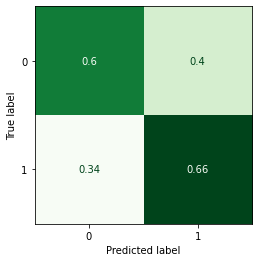

In [403]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_best_gbc, cmap= "Greens", colorbar= False, normalize= "true")

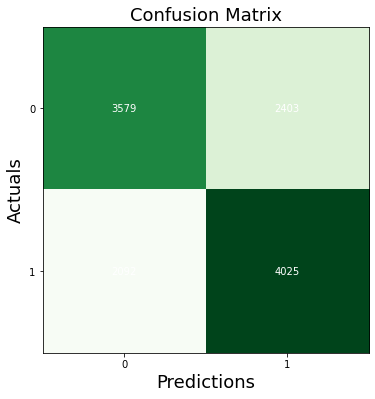

In [405]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

cm_hgb = confusion_matrix(y_test, y_pred_test_best_gbc)
fig, ax = plot_confusion_matrix(conf_mat=cm_hgb, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
pd.crosstab(y_test, y_pred_test_best_gbc, rownames= ["True"], colnames= ["Predicted"], margins= True)

In [ ]:
import plotly.graph_objects as go

In [ ]:
def plot_confusion_matrix2(y_true, y_pred, title):
 cm = confusion_matrix(y_true, y_pred)
 fig = go.Figure(
    go.Heatmap(
        z= cm[::-1],
        y= ["1", "0"],
        x= ["0", "1"],
        hoverongaps= False,
        colorscale= "Greens",
    ),
    layout= dict(
        legend_title_text= "ahjksbdhasbdhas",
        height= 400,
        width= 700,
        title= dict(text= f"<b>{title}</b>", xanchor= "center", yanchor= "top", y=0.85, x=0.5, font_size= 20),
        xaxis= dict(title= "<b>Predictions</b>"),
        yaxis= dict(title= "<b>Actuals</b>"),
        annotations= [
            dict(x= 0, y= 0, font= dict(color= "black"), text= f"{cm[1, 0]}", showarrow= False),
            dict(x= 0, y= 1, font= dict(color= "black"), text= f"{cm[0, 0]}", showarrow= False),
            dict(x= 1, y= 0, font= dict(color= "black"), text= f"{cm[1, 1]}", showarrow= False),
            dict(x= 1, y= 1, font= dict(color= "black"), text= f"{cm[0, 1]}", showarrow= False),
        ]
    )
 )
 fig.show()

In [401]:
plot_confusion_matrix2(y_test, y_pred_test_best_gbc, "Confusion Matrix")

# ROC Kurve

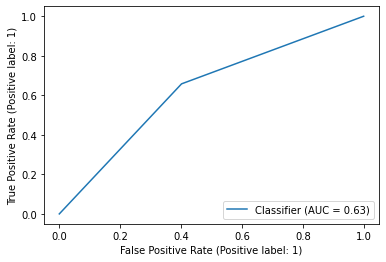

In [404]:
RocCurveDisplay.from_predictions(y_test, y_pred_test_best_gbc)

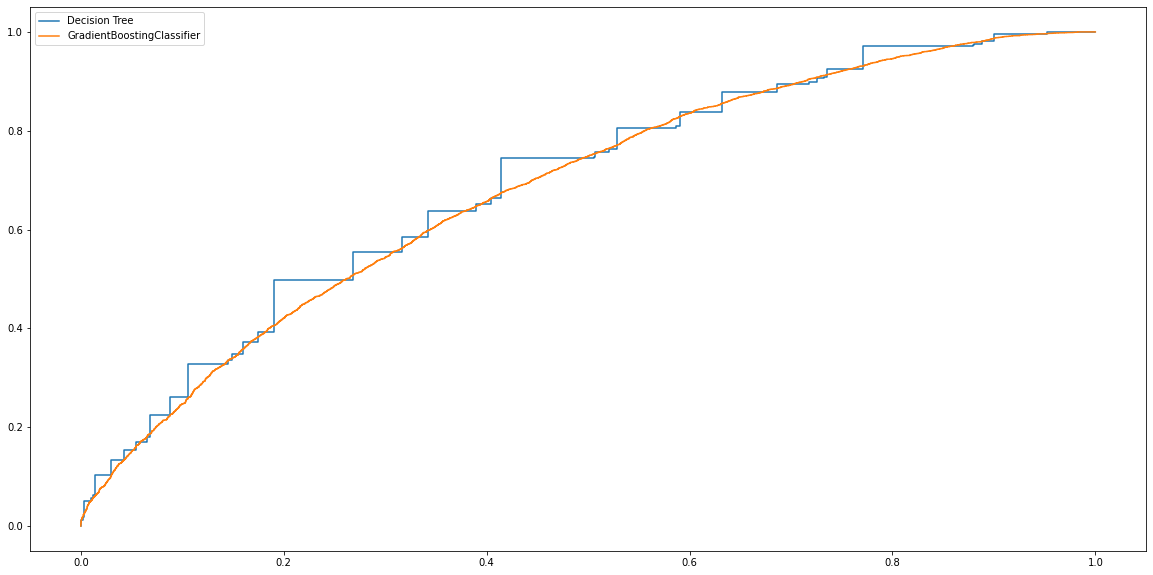

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, best_dtc.predict_proba(X_test)[:,1])
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, best_gbc.predict_proba(X_test)[:,1])

auc_score_gbc = roc_auc_score(y_test, y_pred_test_best_gbc)

plt.figure(figsize= (20,10))
plt.step(x=fpr_dt, y=tpr_dt, label="Decision Tree")
plt.step(x=fpr_lr, y=tpr_lr, label="GradientBoostingClassifier")
plt.legend()

In [104]:
def plot_roc_curve12(X_test, y_test, y_predict):
 plt.figure(figsize= (20,10))
 
 for model in y_predict:
    fpr, tpr, thr = roc_curve(y_test, model[0].predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, model[1])
    plt.step(x=fpr, y=tpr, label=f"{model[2]} (AUC = {auc.round(2)})")
 plt.legend()

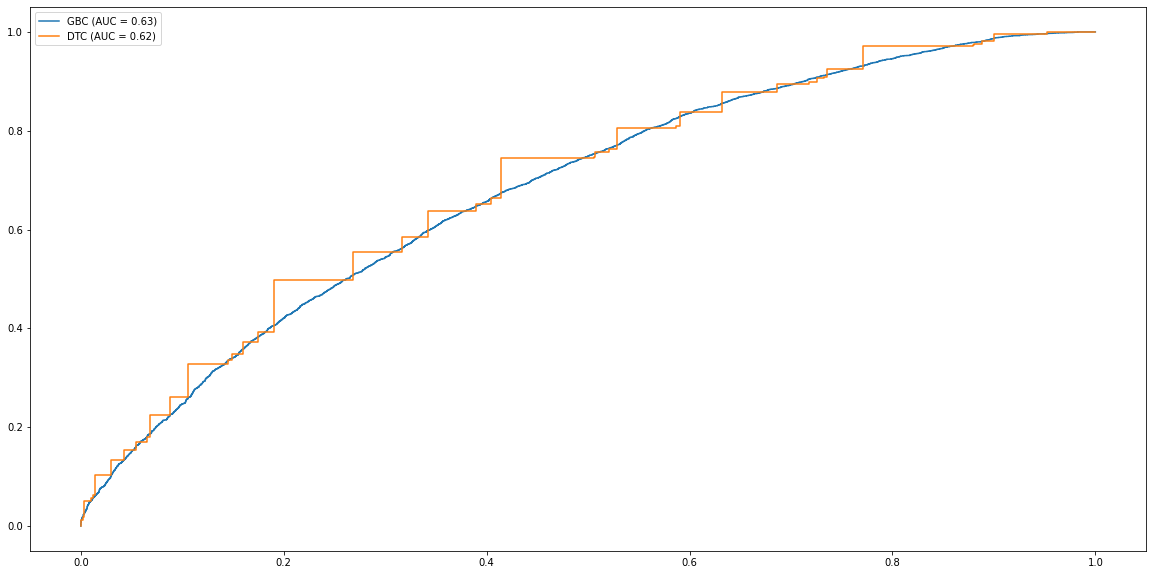

In [105]:
plot_roc_curve12(y_test= y_test, y_predict= [[best_gbc, y_pred_test_best_gbc, "GBC"], [best_dtc, y_pred_test_best_dtc, "DTC"]], X_test= X_test)